[colab](https://colab.research.google.com/github/rufous86/studies/blob/main/DLS_NLP/05_language_modeling/hw_language_modelling.ipynb)

# Домашнее задание. Обучение языковой модели с помощью LSTM (10 баллов)

Это домашнее задание проходит в формате peer-review. Это означает, что его будут проверять ваши однокурсники. Поэтому пишите разборчивый код, добавляйте комментарии и пишите выводы после проделанной работы. 

В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

In [35]:
!pip install datasets -q

Импорт необходимых библиотек

In [36]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords

from collections import Counter
from typing import List

import string


import matplotlib.pyplot as plt
plt.style.use('dark_background')
plt.rcParams['lines.linewidth'] = 1

import time

In [37]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [38]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [39]:
# Загрузим датасет
dataset = load_dataset('imdb')

  0%|          | 0/3 [00:00<?, ?it/s]

In [40]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать: 

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером. 
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```. 
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

In [41]:
sentences = []
word_threshold = 32

# Получить отдельные предложения и поместить их в sentences
for sentence in tqdm(dataset['train']['text']):
    sentences.extend(
        [x.lower() for x in sent_tokenize(sentence) if len(x) < word_threshold]
    )

  0%|          | 0/25000 [00:00<?, ?it/s]

In [42]:
print("Всего предложений:", len(sentences))

Всего предложений: 28827


Посчитаем для каждого слова его встречаемость.

In [43]:
def count_words(dataset, remove_stops=False):
    words = Counter()
    if remove_stops:
        stops = stopwords.words('english')
    else:
        stops = []

    # Расчет встречаемости слов
    for example in tqdm(dataset):
        # Приводим к нижнему регистру и убираем пунктуацию
        processed_text = example.lower().translate(
            str.maketrans('', '', string.punctuation))
        processed_text = [
            word for word in word_tokenize(processed_text)
        ]

        for word in processed_text:
            words[word] += 1
    return words

words = count_words(dataset['train']['text'], remove_stops=False)

  0%|          | 0/25000 [00:00<?, ?it/s]

Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [44]:
vocab_size = 40000

vocab = set(dict(sorted(words.items(), key=lambda x: x[1], reverse=True)[:vocab_size]).keys())
for serv_word in ['<unk>', '<bos>', '<eos>', '<pad>']:
    vocab.add(serv_word)

In [45]:
assert '<unk>' in vocab
assert '<bos>' in vocab 
assert '<eos>' in vocab 
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

In [46]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 40004


### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов). 

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```. 

In [47]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

In [48]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        # Допишите код здесь
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [word2ind.get(word, self.unk_id) for word in self.data[idx].split(' ')]
        tokenized_sentence += [self.eos_id]

        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [49]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)
    
    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [50]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2)
eval_sentences, test_sentences = train_test_split(sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 128

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве. 

Возмоэные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации. 
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве. 

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [51]:
def evaluate(model, criterion, dataloader) -> tuple[float, float]:
    model.eval()
    perplexity = []
    losses = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc=f'Validation'):
            logits = model(batch['input_ids'].flatten(start_dim=0, end_dim=1)) # Посчитайте логиты предсказаний следующих слов
            loss = criterion(logits, batch['target_ids'].flatten()).cpu().detach()
            perplexity.append(torch.exp(loss).item())
            losses.append(loss)
    
    perplexity = sum(perplexity) / len(perplexity)
    loss = sum(losses) / len(losses)

    return perplexity, loss.item()

### Train loop (1 балл)

Напишите функцию для обучения модели. 

In [52]:
def train_model(model, 
                train_dataloader, 
                val_dataloader, 
                criterion, 
                optimizer, 
                num_epoch,
                algo_desc) -> dict:
    # Напишите код здесь
    start = time.time()
    losses = []
    perplexities = []
    val_losses = []
    val_perplexities = []

    for epoch in range(num_epoch):
        epoch_losses = []
        epoch_perplexities = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'].flatten(start_dim=0, end_dim=1))
            loss = criterion(
                logits, batch['target_ids'].flatten())
            
            perplexity = torch.exp(loss).item()
            epoch_perplexities.append(perplexity)
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
        
        losses.append(sum(epoch_losses) / len(epoch_losses))
        perplexities.append(sum(epoch_perplexities) / len(epoch_perplexities))
        print('train_loss:', losses[-1])
        print('train_perplexity:', perplexities[-1])
            
        val_perplexity, val_loss = evaluate(model, criterion, val_dataloader)
        val_losses.append(val_loss)
        val_perplexities.append(val_perplexity)
        
        print('val_loss:', val_losses[-1])
        print('val_perplexity:', val_perplexities[-1])

    history = {
        'algo_desc': algo_desc,
        'train_loss': losses,
        'train_perplexity': perplexities,
        'val_loss': val_losses,
        'val_perplexity': val_perplexities,
        'execution_time': (time.time() - start) / num_epoch
        }
    return history

all_histories = []

Функция для вывода графиков

In [53]:
def plot_result(history):
    print(history['algo_desc'])
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'][1:], c='r', label='train')
    plt.plot(history['val_loss'][1:], c='b', label='val')
    plt.legend()
    plt.title(f'loss, best on val {min(history["val_loss"]):.5f}')

    plt.subplot(1, 2, 2)
    plt.plot(history['train_perplexity'][1:], c='r', label='train')
    plt.plot(history['val_perplexity'][1:], c='b', label='val')
    plt.legend()
    plt.title(f'perplexity, best on val {min(history["val_perplexity"]):.5f}')
    
    plt.show()

### Первый эксперимент (2 балла)

Определите архитектуру модели и обучите её. 

In [54]:
class LanguageModelLinear(nn.Module):
    def __init__(
        self, embed_dim: int, 
        hidden_dim: int, 
        vocab_size: int,
        num_layers: int,
        gru_is_bidirectional: bool):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.GRU(embed_dim, 
                          hidden_dim, 
                          num_layers, 
                          bidirectional=gru_is_bidirectional,
                          batch_first=True)
        
        if gru_is_bidirectional:
            self.linear = nn.Linear(hidden_dim*2, hidden_dim)
        else:
            self.linear = nn.Linear(hidden_dim, hidden_dim)

        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        x, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim] 
        x = self.dropout(self.linear(self.non_lin(x)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(x))  # [batch_size, num_classes]

        return prediction

In [55]:
# Обучите модель здесь
model = LanguageModelLinear(embed_dim=256, 
                            hidden_dim=256, 
                            vocab_size=len(vocab),
                            num_layers=1,
                            gru_is_bidirectional=False).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())
num_epoch = 10

history1 = train_model(model, 
                train_dataloader, 
                eval_dataloader, 
                criterion, 
                optimizer, 
                num_epoch,
                'Language Model Linear с 1 GRU слоем')

all_histories.append(history1)

Training epoch 0::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 4.051338828071046
train_perplexity: 795.8525050568976


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 3.5061113834381104
val_perplexity: 33.609930376035976


Training epoch 1::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 3.4173493042835212
train_perplexity: 30.73935267411543


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 3.271940231323242
val_perplexity: 26.5813548332822


Training epoch 2::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 3.2274841129450507
train_perplexity: 25.398723928967893


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 3.12351655960083
val_perplexity: 22.919326090179712


Training epoch 3::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 3.0977643497741023
train_perplexity: 22.289481294747873


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 3.0301856994628906
val_perplexity: 20.87609441301464


Training epoch 4::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 3.0015307961247903
train_perplexity: 20.235573794960317


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 2.9590227603912354
val_perplexity: 19.43899359745262


Training epoch 5::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.920154348921381
train_perplexity: 18.64725830014898


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 2.9019203186035156
val_perplexity: 18.356803488942376


Training epoch 6::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.848290571191693
train_perplexity: 17.34794611957192


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 2.8629748821258545
val_perplexity: 17.65562698904392


Training epoch 7::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.7821977151691586
train_perplexity: 16.235193758379687


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 2.816795587539673
val_perplexity: 16.856445126828895


Training epoch 8::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.720551596162069
train_perplexity: 15.261587949088923


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 2.7770204544067383
val_perplexity: 16.198264012294533


Training epoch 9::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.653875283773433
train_perplexity: 14.274622500930702


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 2.7579104900360107
val_perplexity: 15.89440630178536


Попробуем увеличить количество GRU слоев

In [56]:
model = LanguageModelLinear(embed_dim=256, 
                            hidden_dim=256, 
                            vocab_size=len(vocab),
                            num_layers=2,
                            gru_is_bidirectional=False).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())
num_epoch = 10

history2 = train_model(model, 
                train_dataloader, 
                eval_dataloader, 
                criterion, 
                optimizer, 
                num_epoch,
                'Language Model Linear с 2 GRU слоями')

all_histories.append(history2)

Training epoch 0::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 4.106244045067887
train_perplexity: 757.169106710023


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 3.5914220809936523
val_perplexity: 36.58813805706733


Training epoch 1::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 3.5300421253752314
train_perplexity: 34.4054965867522


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 3.388986587524414
val_perplexity: 29.875558296136095


Training epoch 2::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 3.3279703677688515
train_perplexity: 28.09153591598595


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 3.2176899909973145
val_perplexity: 25.177002712688616


Training epoch 3::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 3.169710190915271
train_perplexity: 23.960078139331458


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 3.0800435543060303
val_perplexity: 21.936648833013212


Training epoch 4::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 3.042809645773956
train_perplexity: 21.091233543269542


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 2.990339517593384
val_perplexity: 20.059492094326863


Training epoch 5::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.9405740795873148
train_perplexity: 19.03323510733757


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 2.9171948432922363
val_perplexity: 18.636667310664084


Training epoch 6::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.851871670938987
train_perplexity: 17.413527673120658


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 2.859495162963867
val_perplexity: 17.587069857436997


Training epoch 7::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.776371942699285
train_perplexity: 16.14402123445964


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 2.832700729370117
val_perplexity: 17.125612832803643


Training epoch 8::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.7119790493454063
train_perplexity: 15.13524064965011


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 2.78767991065979
val_perplexity: 16.364676720273177


Training epoch 9::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.6348140529506114
train_perplexity: 14.010429008230979


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 2.781796932220459
val_perplexity: 16.278418313085506


Попробуем Bidirectional GRU

In [57]:
# Обучите модель здесь
model = LanguageModelLinear(embed_dim=256, 
                            hidden_dim=256, 
                            vocab_size=len(vocab),
                            num_layers=1,
                            gru_is_bidirectional=True).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())
num_epoch = 10

history3 = train_model(model, 
                train_dataloader, 
                eval_dataloader, 
                criterion, 
                optimizer, 
                num_epoch,
                'Language Model Linear с Bidirectional GRU слоем')

all_histories.append(history3)

Training epoch 0::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 3.409826941253072
train_perplexity: 571.2899045470011


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 2.2018380165100098
val_perplexity: 9.115258938443345


Training epoch 1::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 1.695520520868881
train_perplexity: 5.723859710587981


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 1.1404153108596802
val_perplexity: 3.1465214227153138


Training epoch 2::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.9714996356990456
train_perplexity: 2.6743529646436155


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.7020079493522644
val_perplexity: 2.0258235836451033


Training epoch 3::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.6297745271611609
train_perplexity: 1.887138472736211


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.4889620244503021
val_perplexity: 1.635530512944787


Training epoch 4::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.432169774783909
train_perplexity: 1.545036881668133


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.35223037004470825
val_perplexity: 1.4255086689923717


Training epoch 5::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.3016869479286078
train_perplexity: 1.3543461403135437


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.2666381299495697
val_perplexity: 1.3081703597465448


Training epoch 6::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.21042589468685963
train_perplexity: 1.235351927372632


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.21119384467601776
val_perplexity: 1.2373806343669385


Training epoch 7::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.1409487910362897
train_perplexity: 1.1519601759989617


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.16716867685317993
val_perplexity: 1.183952457081955


Training epoch 8::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.08866731470543376
train_perplexity: 1.0930120345637284


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.13899247348308563
val_perplexity: 1.1509454756711437


Training epoch 9::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.050525830050117404
train_perplexity: 1.0519250703780032


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.12223237007856369
val_perplexity: 1.131901813819345


Попробуем 2 слоя Bidirectional GRU

In [58]:
model = LanguageModelLinear(embed_dim=256, 
                            hidden_dim=256, 
                            vocab_size=len(vocab),
                            num_layers=2,
                            gru_is_bidirectional=True).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())
num_epoch = 10

history4 = train_model(model, 
                train_dataloader, 
                eval_dataloader, 
                criterion, 
                optimizer, 
                num_epoch,
                'Language Model Linear с 2 Bidirectional GRU слоями')

all_histories.append(history4)

Training epoch 0::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 3.7299652442089104
train_perplexity: 504.21765009737805


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 2.7990987300872803
val_perplexity: 16.58471986888784


Training epoch 1::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.6119239422497826
train_perplexity: 13.809197799935525


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 2.3606696128845215
val_perplexity: 10.690099024139675


Training epoch 2::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.307377881766683
train_perplexity: 10.136791658664935


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 2.1351325511932373
val_perplexity: 8.528938694337828


Training epoch 3::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.0513521564599557
train_perplexity: 7.857288392209217


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 1.8299739360809326
val_perplexity: 6.2870879004486895


Training epoch 4::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 1.7516690966832704
train_perplexity: 5.815490472382604


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 1.5683034658432007
val_perplexity: 4.839186406768529


Training epoch 5::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 1.476297388419262
train_perplexity: 4.416861952997703


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 1.2454670667648315
val_perplexity: 3.499137327734348


Training epoch 6::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 1.126870311096887
train_perplexity: 3.1160928847381424


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.8941748142242432
val_perplexity: 2.4577534008870083


Training epoch 7::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.8118575175822769
train_perplexity: 2.266726602506901


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.6510363817214966
val_perplexity: 1.9254195795649975


Training epoch 8::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.5876920997108543
train_perplexity: 1.806824447041717


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.4968806207180023
val_perplexity: 1.6493175314590993


Training epoch 9::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.4350562387079165
train_perplexity: 1.548757617644842


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.3941632807254791
val_perplexity: 1.487561145714954


### Второй эксперимент (2 балла)

Попробуйте что-то поменять в модели или в пайплайне обучения, идеи для экспериментов можно подсмотреть выше. 

Попробуем в первой модели с 1 слоем скрытого состояния и однонаправленным GRU добавить сверточный слой перед GRU

In [59]:
class LanguageModelConvBeforeGRU(nn.Module):
    def __init__(self, vocab_size: int, 
                 embed_dim: int, 
                 hidden_dim: int, 
                 kernel_size: int,
                 b_norm: bool):
        super().__init__()
        self.b_norm = b_norm
        self.norm = nn.BatchNorm1d(hidden_dim)

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.conv = nn.Conv1d(embed_dim, hidden_dim, kernel_size, padding='same')
        self.gru = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(0)
        x = x.permute(0, 2, 1) # swap dimensions for Conv1d
        x = self.conv(x)
        x = nn.functional.relu(x)

        if self.b_norm:
            x = self.norm(x)

        x = x.permute(0, 2, 1) # swap dimensions back
        x = x.squeeze(0)
        x, _ = self.gru(x)
        x = self.fc(x)
        return x


In [60]:
model = LanguageModelConvBeforeGRU(embed_dim=256, 
                          hidden_dim=256, 
                          vocab_size=len(vocab),
                          kernel_size=3,
                          b_norm=False).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())
num_epoch = 10

history5 = train_model(model, 
                train_dataloader, 
                eval_dataloader, 
                criterion, 
                optimizer, 
                num_epoch,
                'Language Model Conv Before GRU')

all_histories.append(history5)

Training epoch 0::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.643225908279419
train_perplexity: 490.0403805859181


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 1.2718204259872437
val_perplexity: 3.5902210758850637


Training epoch 1::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.9543636902261176
train_perplexity: 2.6433399513940126


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.6624841094017029
val_perplexity: 1.947164535522461


Training epoch 2::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.561817534226739
train_perplexity: 1.7631093981516295


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.4340217113494873
val_perplexity: 1.5476042886750887


Training epoch 3::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.3703193652201753
train_perplexity: 1.4520138199158137


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.3129766285419464
val_perplexity: 1.3703912665358686


Training epoch 4::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.25399015638051115
train_perplexity: 1.2909668328353714


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.24244704842567444
val_perplexity: 1.2766602102634126


Training epoch 5::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.1739261571050349
train_perplexity: 1.190992803204784


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.1940017193555832
val_perplexity: 1.216096191279656


Training epoch 6::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.11899060908272781
train_perplexity: 1.126899898381523


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.15422964096069336
val_perplexity: 1.1684233709774186


Training epoch 7::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.07762331599935643
train_perplexity: 1.0809912885750197


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.12590010464191437
val_perplexity: 1.1356617718671276


Training epoch 8::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.04752057938944569
train_perplexity: 1.0487801258076621


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.10579618811607361
val_perplexity: 1.1130198809952863


Training epoch 9::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.02733854590837962
train_perplexity: 1.027757763203995


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.09323006868362427
val_perplexity: 1.0990468073735196


Добавим слой батч нормализации после сверток

In [61]:
model = LanguageModelConvBeforeGRU(embed_dim=256, 
                          hidden_dim=256, 
                          vocab_size=len(vocab),
                          kernel_size=3,
                          b_norm=True).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())
num_epoch = 10

history6 = train_model(model, 
                train_dataloader, 
                eval_dataloader, 
                criterion, 
                optimizer, 
                num_epoch,
                'Language Model Conv Before GRU с батч нормализацией')

all_histories.append(history6)

Training epoch 0::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.0717358434397872
train_perplexity: 563.5497809813168


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.7114198207855225
val_perplexity: 2.045102471798922


Training epoch 1::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.5293405385307186
train_perplexity: 1.7108975800361423


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.34626340866088867
val_perplexity: 1.416796099823133


Training epoch 2::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.2699106976966173
train_perplexity: 1.312935842334895


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.21084599196910858
val_perplexity: 1.236642285785844


Training epoch 3::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.1395925629410625
train_perplexity: 1.1508656957531502


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.14386224746704102
val_perplexity: 1.1561619117196682


Training epoch 4::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.06627033561344634
train_perplexity: 1.0688922003487855


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.10122447460889816
val_perplexity: 1.1077346675163877


Training epoch 5::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.02344041320788597
train_perplexity: 1.023799977249862


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.079985611140728
val_perplexity: 1.0844248406654966


Training epoch 6::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.007507519301243167
train_perplexity: 1.007540591513913


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.07470274716615677
val_perplexity: 1.0787230308076976


Training epoch 7::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.003963042193385695
train_perplexity: 1.0039714047921955


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.07337702810764313
val_perplexity: 1.0773092107435243


Training epoch 8::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.0027917528104356064
train_perplexity: 1.002795822712598


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.07272838801145554
val_perplexity: 1.0766225388619752


Training epoch 9::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.0021560389435340685
train_perplexity: 1.0021584554271803


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.0723520964384079
val_perplexity: 1.0762270056040941


Language Model Linear с 1 GRU слоем


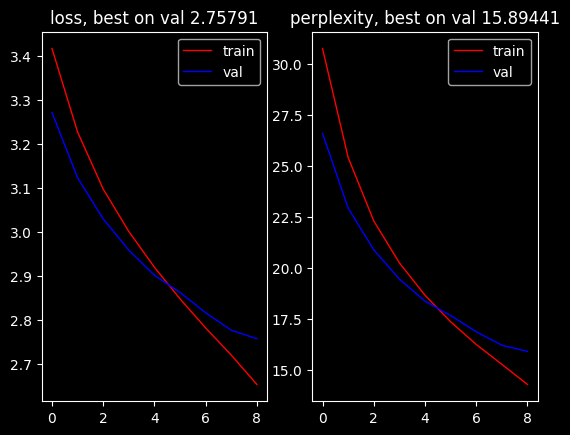

Language Model Linear с 2 GRU слоями


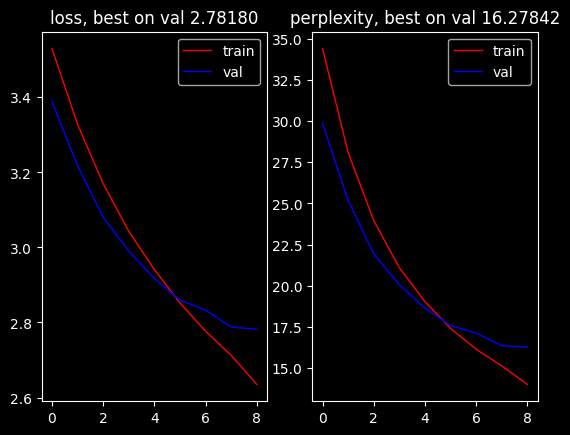

Language Model Linear с Bidirectional GRU слоем


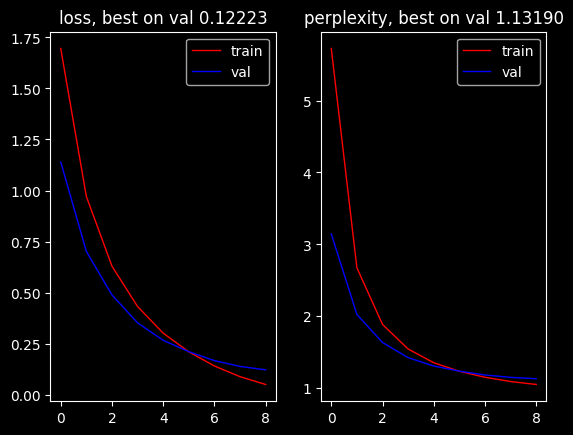

Language Model Linear с 2 Bidirectional GRU слоями


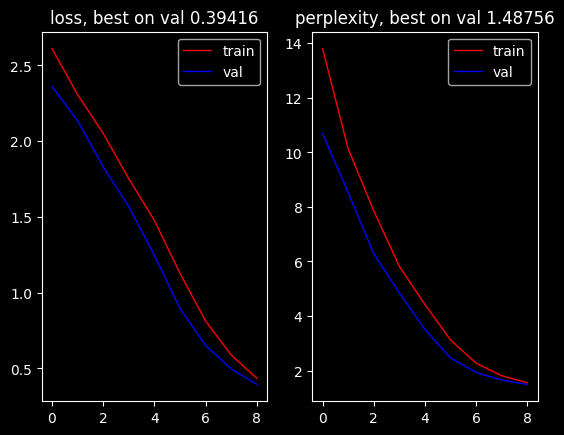

Language Model Conv Before GRU


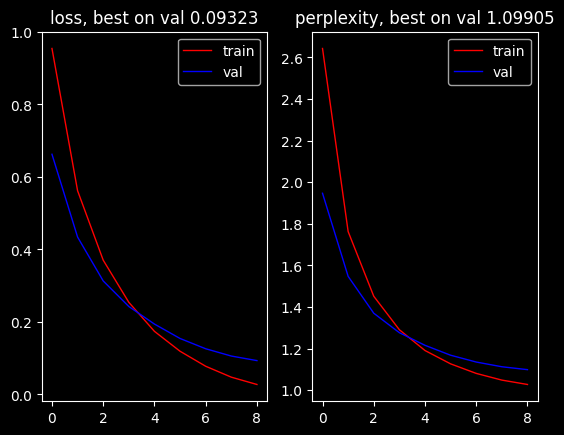

Language Model Conv Before GRU с батч нормализацией


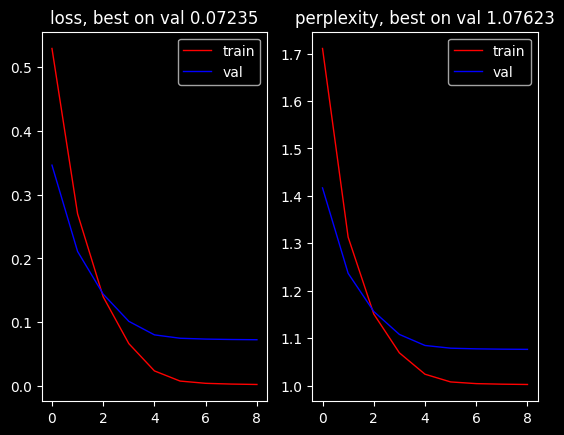

In [62]:
for history in all_histories:
    plot_result(history)

Сравним время выполнения алгоритмов

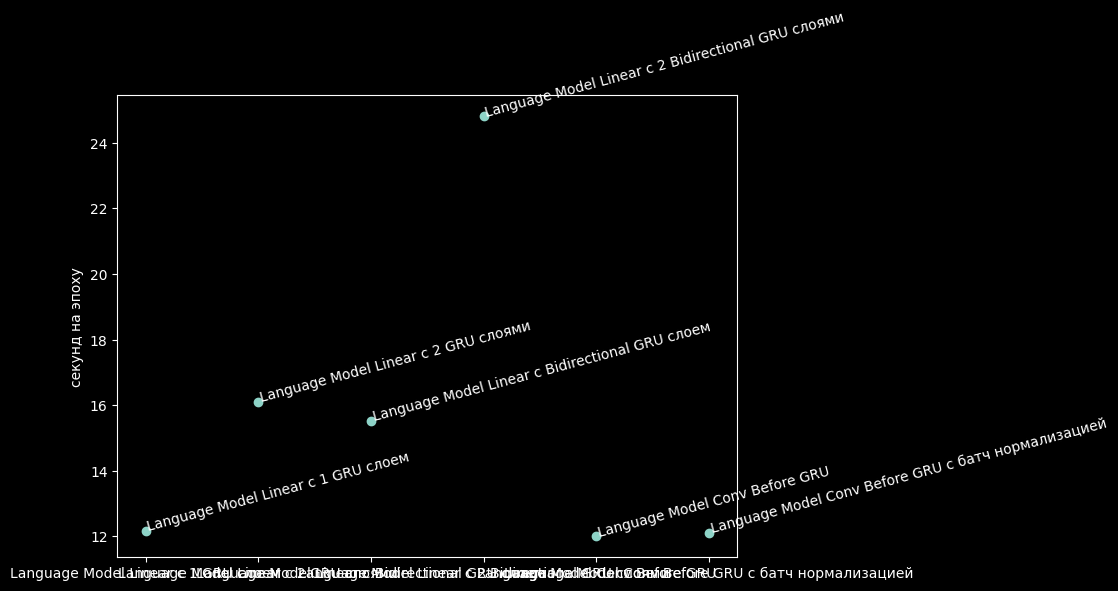

In [76]:
times = [(history['algo_desc'], history['execution_time']) for history in all_histories]

names, times = zip(*times)
plt.figure(figsize=(8, 6))
plt.scatter(names, times)

for name, time in zip(names, times):
    plt.annotate(name, (name, time), rotation=15)

plt.ylabel('секунд на эпоху')
plt.show()

### Отчет (2 балла)

Опишите проведенные эксперименты. Сравните перплексии полученных моделей. Предложите идеи по улучшению качества моделей. 

In [64]:
def generate_sequence(model, starting_seq: str, max_seq_len: int = 8) -> str:
    device = 'cpu'
    model = model.to(device)
    input_ids = [word2ind['<bos>']] + [
        word2ind.get(word, word2ind['<unk>']) for word in word_tokenize(starting_seq)]
    input_ids = torch.LongTensor(input_ids).to(device)

    model.eval()
    with torch.no_grad():
        for i in range(max_seq_len):
            next_word_distribution = model(input_ids)[-1]
            next_word = next_word_distribution.squeeze().argmax()
            input_ids = torch.cat([input_ids, next_word.unsqueeze(0)])

            if next_word.item() == word2ind['<eos>']:
                break
    
    words = ' '.join([ind2word[idx.item()] for idx in input_ids])

    return words

generate_sequence(model, starting_seq='when you think ')

'<bos> when you think army green green sean supporting sean mainly dawson'